# Eigenfaces and SVM for face classification

Using the Labeled Faces in the Wild dataset, this notebook demonstrates a machine learning algorithm for face image classification. Although outdated due the explosion of deep learning in recent years (which generally make use of massive external training examples such as 4 million for DeepFace by Facebook and 126 million for FaceNet by Google), a classic method for this task is to train a classifier after reducing dimensionality using eigenfaces. I have chosen to use support vector machine classification for this task as it is a robust general classifier. 

The steps taken are as follows:
1. Split the data into a training and test set
2. Find the Eigenfaces from the training dataset i.e. perform a principal component analysis. The number of components to keep will be an important parameter to choose here.
3. Train an SVM using the training set. There are two hyperparameters to tune at this stage. `C` which controls how *soft* margins can be and helps prevent overfitting. `gamma` controls the shapes of the kernels used allowing the classifier to work on non-linearly separable data.
4. Train the data using cross-validation while tuning the above three parameters using a grid search
5. Use the best performing models from the cross-validation grid search to predict the names of the faces from the test data.
6. Assess the performance of the model.

Some assumptions taken:
 - all the images do contain faces.
 - all the faces are labeled.
 - all the faces are reasonably well aligned.
 - there are no unseen classes in the test set.
 - there are a reasonable amount of training examples for each class. I have only kept classes (i.e. people) for which there are 30 or more labeled examples.

In [92]:
import math
import os
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Load the data (note that a detailed explanation of data preprocessing is provided in a separate notebook)

In [4]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=0.4)

Check that the images loaded correctly

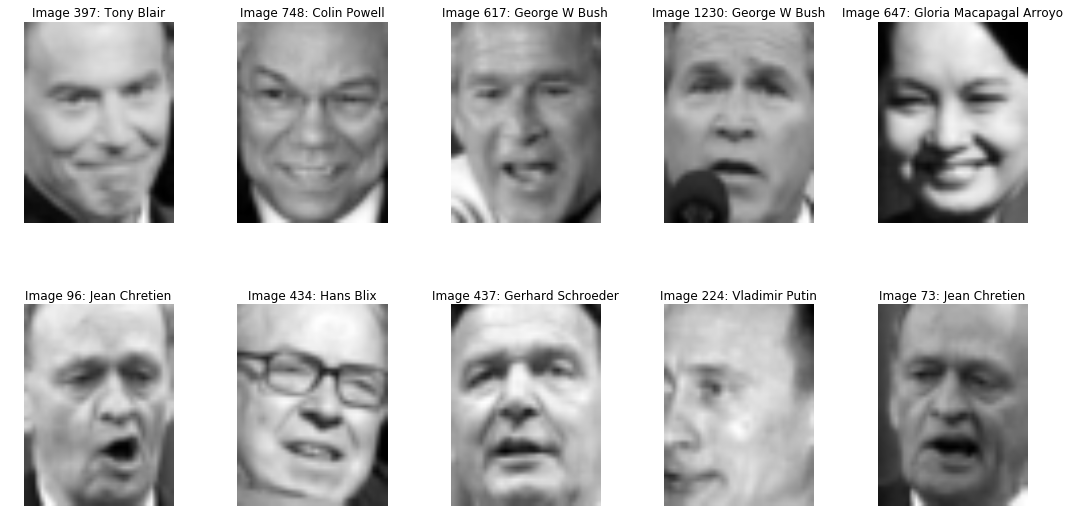

In [5]:
def get_name(ind):
    return lfw_people.target_names[lfw_people.target[ind]]

row_total = 2
col_total = 5
fig = plt.figure()
# If the images don't fit well on your screen resolution, adjust the multipliers in
# the next two lines (i.e. the 3 and 4) and maybe the col_total above
fig.set_figheight(4*row_total)
fig.set_figwidth(3*col_total)
for row, col in itertools.product(range(row_total), range(col_total)):
    ax = plt.subplot2grid((row_total, col_total), (row, col))
    ax.axis('off')
    #ind = row*col_total + col # Uncomment for sequential images instead of random selection
    ind = np.random.randint(0, lfw_people.data.shape[0])
    ax.imshow(lfw_people.images[ind],cmap='gray')
    ax.set_title('Image {}: {}'.format(ind,get_name(ind)))
plt.tight_layout()

Prepare the data

In [7]:
X = lfw_people.data
y = lfw_people.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Train the model

In [10]:
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', SVC())
])

N_FEATURES_OPTIONS = [100, 150, 200, 500]
C_OPTIONS = [1,3,10,30,100]
GAMMA_OPTIONS = [0.0001, 0.0003, 0.001, 0.003]
param_grid = [
    {
        'reduce_dim': [PCA(whiten=True)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
        'classify__gamma' : GAMMA_OPTIONS
    }
]

In [12]:
grid = GridSearchCV(pipe, param_grid=param_grid)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)], 'classify__gamma': [0.0001, 0.0003, 0.001, 0.003], 'reduce_dim__n_components': [100, 150, 200, 500], 'classify__C': [1, 3, 10, 30, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Assess the performance

In [42]:
y_pred = grid.predict(X_test)

In [67]:
print('F1 score: {:.4f}'.format(f1_score(y_test,y_pred,average='macro')))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))

F1 score: 0.6361
Accuracy: 69.20%


The accuracy of this model doesn't come close to those of the modern cutting edge deep learning models, but it does do a fairly reasonable job considering its simplicity. The F1 score and accuracy reported above are average values. A confusion matrix and classification report allow us to delve a little deeper into the performance on a per class basis:

In [105]:
# Code adapted from scikit-learn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm2 = cm

    thresh = cm.max() * 0.50
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm2[i, j]*100+0.5),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
                           precision    recall  f1-score   support

         Alejandro Toledo       1.00      0.75      0.86        12
             Alvaro Uribe       0.75      0.27      0.40        11
             Andre Agassi       0.83      0.45      0.59        11
             Ariel Sharon       0.67      0.60      0.63        20
    Arnold Schwarzenegger       0.40      0.24      0.30        17
             Colin Powell       0.62      0.88      0.72        73
            David Beckham       0.67      0.25      0.36         8
          Donald Rumsfeld       0.62      0.65      0.63        37
            George W Bush       0.67      0.90      0.77       165
        Gerhard Schroeder       0.72      0.76      0.74        37
  Gloria Macapagal Arroyo       1.00      1.00      1.00         8
          Guillermo Coria       1.00      0.40      0.57        10
                Hans Blix       0.75      0.64      0.69        14
              Hugo Chavez       0

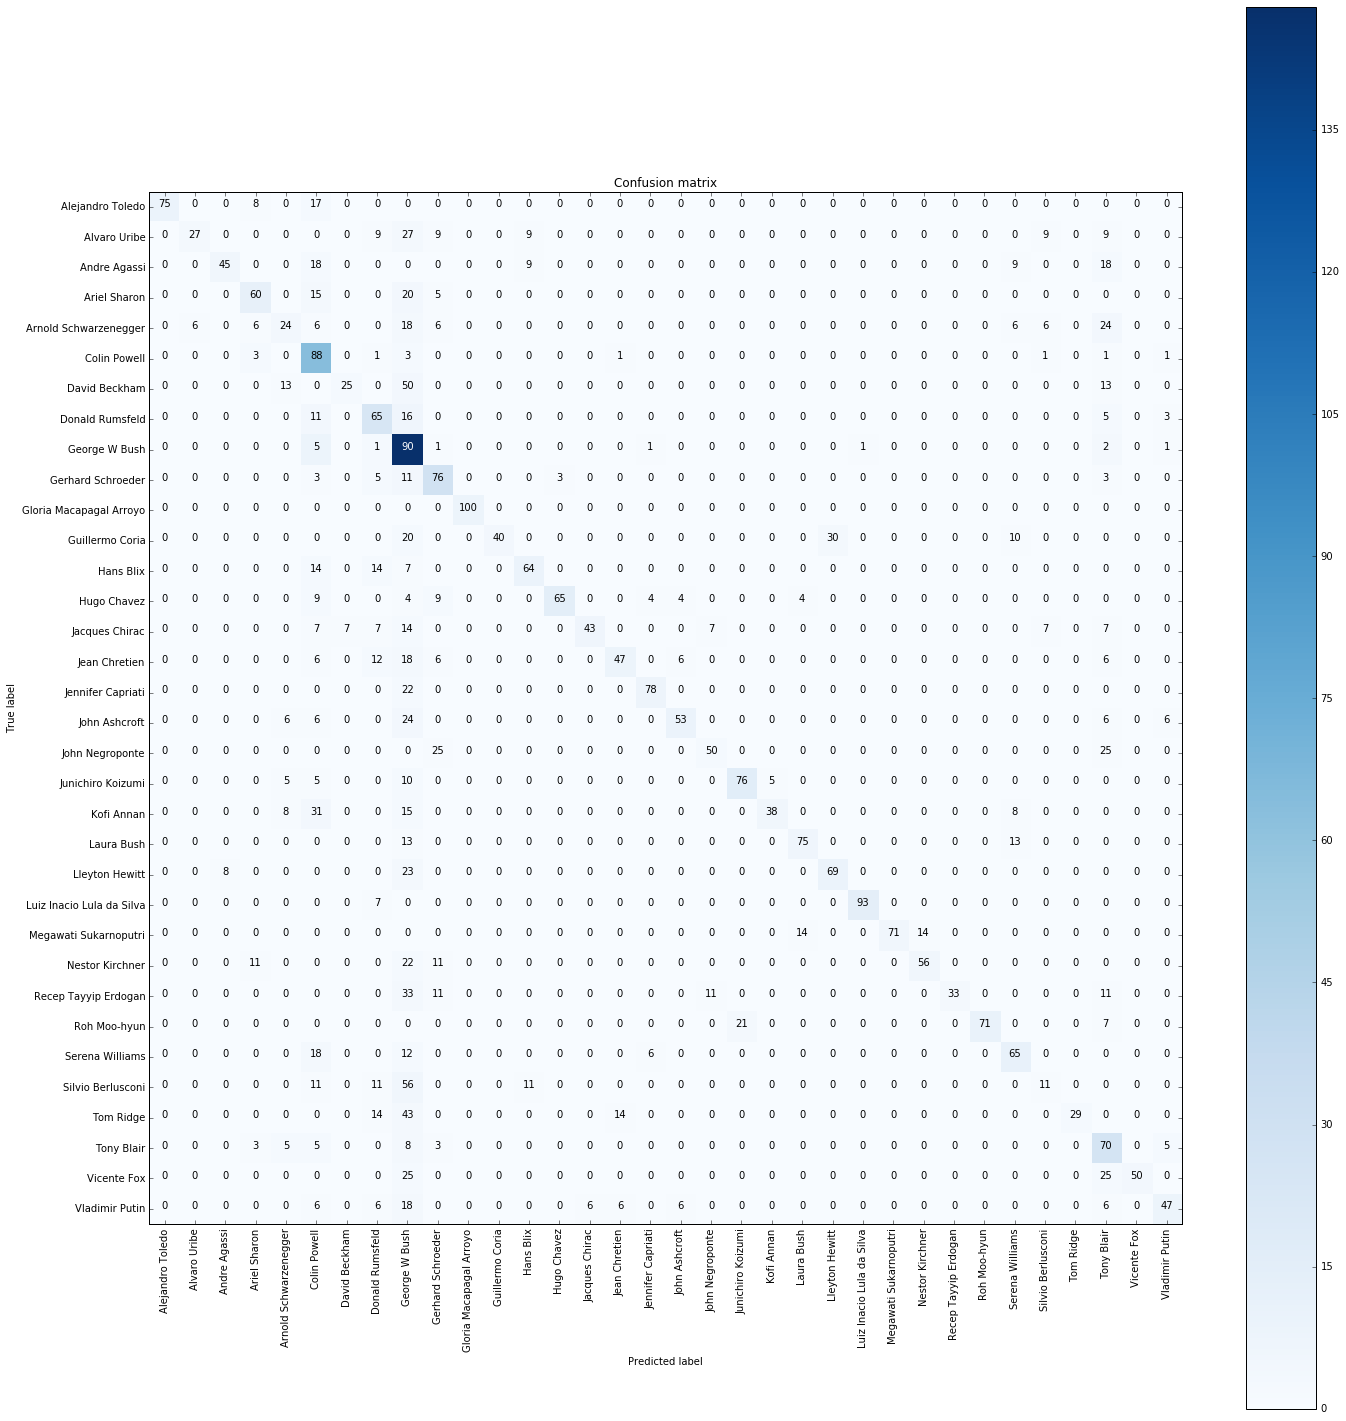

In [49]:
cm=confusion_matrix(lfw_people.target_names[y_test], lfw_people.target_names[y_pred], labels=lfw_people.target_names)
plot_confusion_matrix(cm,lfw_people.target_names,normalize=True)
print(classification_report(y_test, y_pred, target_names=lfw_people.target_names))

The confusion matrix shows false positives on the columns and false negatives on the rows. Consider the case of George W Bush, the class with by far the greatest representation in the dataset. Scanning his row, we see that the model only misclassified (i.e. false negatives) about ten percent of his 165 test cases. However looking at his column we see that the algorithm overzealously classifies other people as George W Bush, i.e. a large false positive rate. This is an indication that the model may have overfit to this particular skewed class. Similarly with Colin Powell, the second most represented.

Another interesting observation is that Roh Moo-hyun and Junichiro Koizumi, while misclassifying close to 30 percent of the time, only misclassified as each other. It may be interesting to visually inspect these images to see if they appear similar to the human eye as well:

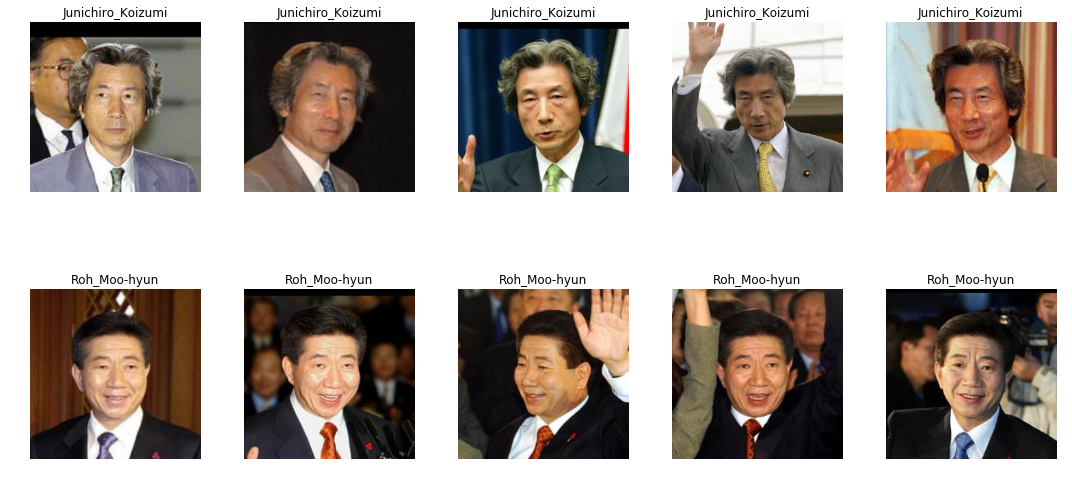

In [95]:
path = r"C:\Users\Carla\Desktop\Dan\LFW\lfw" 

name_1 = 'Junichiro_Koizumi'
name_2 = 'Roh_Moo-hyun'
row_total = 2
col_total = 5
fig = plt.figure()
fig.set_figheight(4*row_total)
fig.set_figwidth(3*col_total)
row = -1
for (dirpath, _, _) in os.walk(path):
    name = dirpath.split('\\')[-1]
    if name in [name_1,name_2]:
        row += 1
        for (_, _, filenames) in os.walk(dirpath):
            col = 0
            for filename in filenames:
                if col < col_total:
                    ax = plt.subplot2grid((row_total, col_total), (row, col))
                    ax.axis('off')
                    image = cv2.imread(os.sep.join([dirpath, filename]))
                    plt.imshow(image[:,:,::-1])
                    ax.set_title('{}'.format(name))
                    col +=1
plt.tight_layout()

These two are not difficult at all for a human to distinguish so it is dissapointing that the model struggles on this case.

Finally, we visually inspect the images of George W Bush that were misclassified:

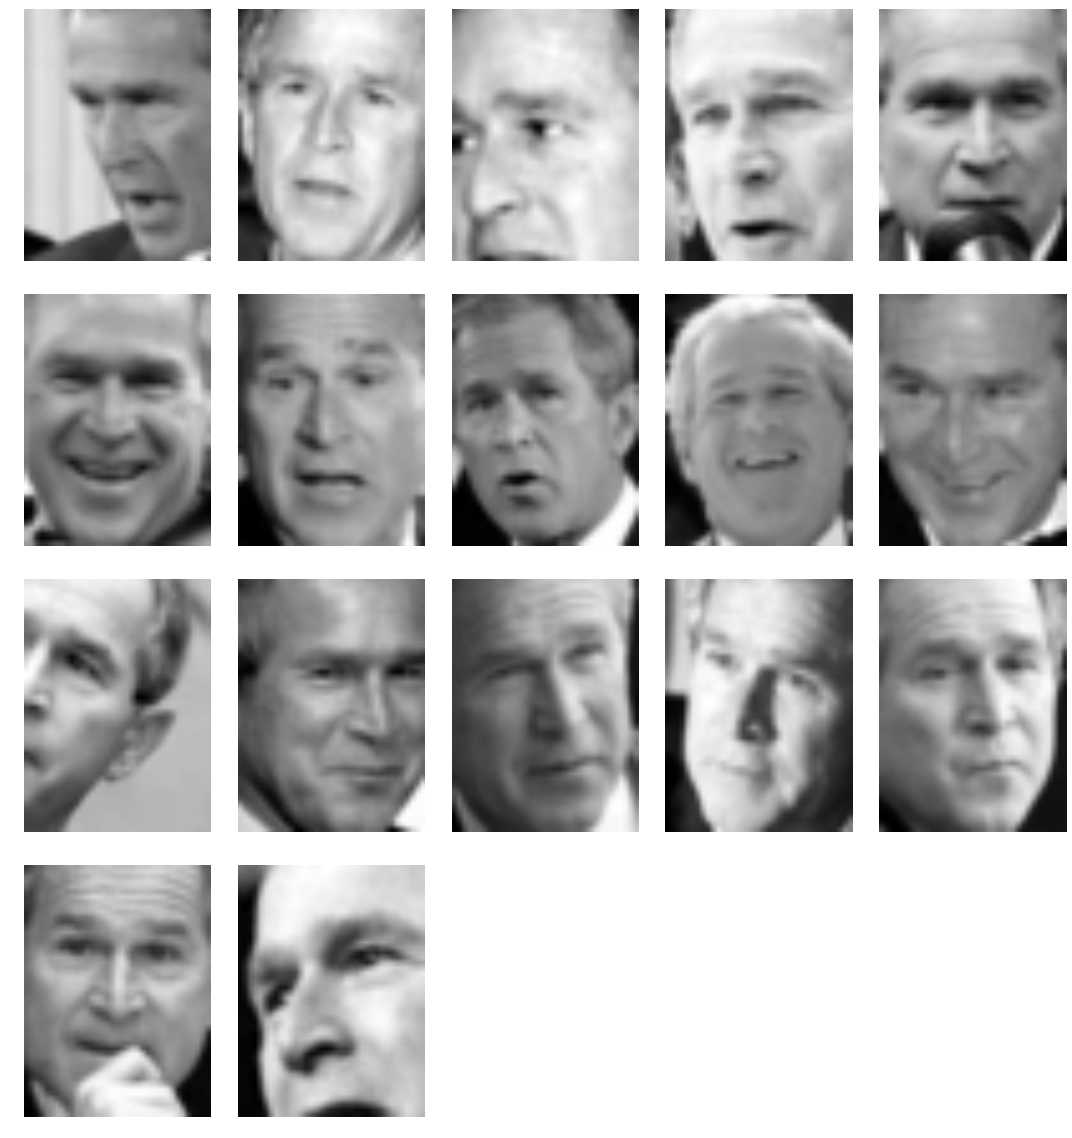

In [104]:
filter = (y_test==8) & (y_pred != 8)
total = sum(filter)
misclassified_george = X_test[filter]

row_total = 4
col_total = 5
fig = plt.figure()
fig.set_figheight(4*row_total)
fig.set_figwidth(3*col_total)
for row, col in itertools.product(range(row_total), range(col_total)):
    ind = row*col_total + col
    if ind < total:
        ax = plt.subplot2grid((row_total, col_total), (row, col))
        ax.axis('off')
        ind = row*col_total + col
        ax.imshow(misclassified_george[ind].reshape(50,37),cmap='gray')
plt.tight_layout()

These images give us some insight on where we might improve the model. It seems to struggle for images that are poorly aligned, poorly cropped and partially occluded. This indicates that improvements to the preprocessing stage could lead to improvements in the final results. It also appears as if he has his eyebrows are raised in many of these images. It could be that the dataset is too small for the model to learn a change of expression like this. Gathering external data may be a solution but further investigation as to the nature of the error (i.e. is it high bias or high variance) is always recommended before spending resources gathering additional data.